In [1]:
# import libraries
import numpy as np
import argparse
import cv2
import easydict
from imutils.object_detection import non_max_suppression
import time

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline


[INFO] text detection took 0.422292 seconds


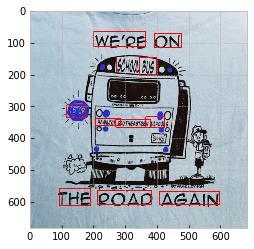

In [3]:
# construct the argument parser and parse the arguments
args=easydict.EasyDict({
    'image':'./Images/textimage3.jpg',
    'east_model':'./frozen_east_text_detection.pb',
    'min_confidence':0.5, #Probability threshold to determine text.
    'width':320, #Resized image width — must be multiple of 32
    'height':320 #Resized image height — must be multiple of 32
})

# load the input image and grab the image dimensions
im2=cv2.imread(args['image'])
orig=im2.copy()
(H,W)=im2.shape[:2]
# set the new width and height
(newW, newH)=(args['width'],args['height'])
rW = W / float(newW)
rH = H / float(newH)
# resize the image
im2=cv2.resize(im2,(newW,newH))
(H,W)=im2.shape[:2]

'''
In order to perform text detection using OpenCV and the EAST deep learning 
model, we need to extract the output feature maps of two layers
'''

'''
define the two output layer names for the EAST detector model that we are 
interested, the first is the output probabilities and the second can be used 
to derive the bounding box coordinates of text
'''
output_layers=[]
# The first layer is our output sigmoid activation which gives us the probability of a region containing text or not.
output_layers.append('feature_fusion/Conv_7/Sigmoid')
# The second layer is the output feature map that represents the “geometry” of the image, it is used to derive the bounding box coordinates of the text in the input image
output_layers.append('feature_fusion/concat_3')


# load the pre-trained EAST text detector into memory 
net=cv2.dnn.readNet(args['east_model'])
# create a 4D blob from the image
blob=cv2.dnn.blobFromImage(im2,1.0,(W,H),(123.68, 116.78, 103.94),swapRB=True, crop=False)
start=time.time()
# to run the model for predicting text, set the blob  as input
net.setInput(blob)
# perform a forward pass of the model to obtain the two output feature maps
(scores, geometry) = net.forward(output_layers)
end=time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))


# number of rows and columns from the scores volume
(num_rows,num_columns)=scores.shape[2:4]
#initialize our set of bounding box rectangles to store the bounding box (x, y)-coordinates for text regions
rects=[]
# Stores the probability associated with each of the bounding boxes in rects
confidences=[]
for y in range(0,num_rows):
    # extract the scores (probabilities)
    scoresData = scores[0, 0, y]
    # derive potential bounding box coordinates that surround text
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    # loop over the number of columns
    for x in range(0, num_columns):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < args["min_confidence"]:
            continue
            
        '''
        The EAST text detector naturally reduces volume size as the image passes 
        through the network, our volume size is actually 4x smaller than our input 
        image so we multiply by four to bring the coordinates back into respect of 
        our original image.
        '''   
        # compute the offset factor as our resulting feature maps will be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        # extract the rotation angle for the prediction and then compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        # use the geometry volume to derive the width and height of the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        # compute both the starting and ending (x, y)-coordinates for the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        # add the bounding box coordinates and probability score to our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    startX=int(startX*rW)
    startY=int(startY*rH)
    endX = int(endX *rW)
    endY = int(endY *rH)
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (255, 0, 0), 2)
plt.grid('False')
plt.imshow(orig)

## Deep Learning based Text Detector in Videos using OpenCV and the EAST text detector.

In [ ]:
import numpy as np
import cv2
import argparse
import time
import imutils
from imutils.video import VideoStream   # to access a webcam
from imutils.video import FPS           #  to benchmark our frames per second
from imutils.object_detection import non_max_suppression
import easydict


# construct the argument parser and parse the arguments
args=easydict.EasyDict({
    'video':None,                  #path to our input video
    'east_model':'./frozen_east_text_detection.pb',             #EAST scene text detector model
    'min_confidence':0.5,      #Probability threshold to determine text
    'width':320,               #Resized image width
    'height':320               #Resized image height
})


# resize the frame dimenisons
(W,H)=(None,None)
(newW,newH)=(args['width'],args['height'])
(rW,rH)=(None, None)


'''
In order to perform text detection using OpenCV and the EAST deep learning 
model, we need to extract the output feature maps of two layers
'''
output_layers=[]
# The first layer is our output sigmoid activation which gives us the probability of a region containing text or not.
output_layers.append('feature_fusion/Conv_7/Sigmoid')
# The second layer is the output feature map that represents the “geometry” of the image, it is used to derive the bounding box coordinates of the text in the input image
output_layers.append('feature_fusion/concat_3')


# load the pre-trained EAST text detector into memory 
net=cv2.dnn.readNet(args['east_model'])
cap = cv2.VideoCapture(args['video'] if args['video'] else 0)

if cap.isOpened()==False:
    print("can't open")   
# start the FPS throughput estimator    
fps=FPS().start()
# loop over frames from the video stream
while True:
    # grab the current frame
    ret,frame=cap.read()
    if not ret:
        cv2.waitKey()
        break
    frame=imutils.resize(frame,width=1000)
    orig=frame.copy()
    (H,W)=frame.shape[:2]
    rW=W/float(newW)
    rH=H/float(newH)
    frame=cv2.resize(frame,(newW,newH))
    # create a 4D blob from the image
    blob=cv2.dnn.blobFromImage(frame,1.0,(newW,newH),(123.68, 116.78, 103.94),swapRB=True, crop=False)
    # to run the model for predicting text, set the blob  as input
    net.setInput(blob)
    # perform a forward pass of the model to obtain the two output feature maps
    (scores, geometry) = net.forward(output_layers)
    # number of rows and columns from the scores volume
    (num_rows,num_columns)=scores.shape[2:4]
    #initialize our set of bounding box rectangles to store the bounding box (x, y)-coordinates for text regions
    rects=[]
    # Stores the probability associated with each of the bounding boxes in rects
    confidences=[]
    for y in range(0,num_rows):
        # extract the scores (probabilities)
        scoresData = scores[0, 0, y]
        # derive potential bounding box coordinates that surround text
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        # loop over the number of columns
        for x in range(0, num_columns):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < args["min_confidence"]:
                continue
                
            '''
            The EAST text detector naturally reduces volume size as the image passes 
            through the network, our volume size is actually 4x smaller than our input 
            image so we multiply by four to bring the coordinates back into respect of 
            our original image.
            '''   
            # compute the offset factor as our resulting feature maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    
    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    boxes=non_max_suppression(np.array(rects),probs=confidences)
    # loop over the bounding boxes
    for (startX,startY,endX,endY) in boxes:
        # scale the bounding box coordinates based on the respective ratios
        startX=int(startX*rW)
        startY=int(startY*rH)
        endX=int(endX*rW)
        endY=int(endY*rH)
        # draw the bounding box on the frame
        cv2.rectangle(orig,(startX,startY),(endX,endY),(0,255,255),2)
    
    
    # update the FPS counter
    fps.update()
    if ret==True:
        cv2.imshow('Detect text',orig)
        if cv2.waitKey(25) & 0xFF==27:  # 0xFF means escape key which we wait for
            break
    else:
        break
        
# stop the timer and display FPS information        
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

cap.release()
cv2.destroyAllWindows()    
    

